# PROJECT TYPES  AND TRENDS IN KICKSTARTER

## Problem Statement
Kickstarter hosts diverse project types with varying outcomes, yet it is unclear why some categories achieve high success rates while others consistently struggle. There is limited understanding of which project types attract faster funding growth, which generate higher contributions per backer, and how seasonality influences performance. Without these insights, creators may set unrealistic goals or launch at suboptimal times, reducing their chances of success.

## Goals:
- Find most & least successful types.
- Highlight funding growth.
- Identify risky categories.
- Spot top-contributing Types
- Understand seasonal effects.


## Preparing and Cleaning the Data

In [86]:
import pandas as pd
import numpy as np

In [87]:
kickstarter_raw = pd.read_excel("DAB14_kickstarterscrape_dataset.xlsx")

In [88]:
missing_counts = kickstarter_raw.isna().sum().sort_values(ascending=False)
print(missing_counts)


location             1322
reward levels          59
pledged                12
name                    2
project id              0
subcategory             0
category                0
status                  0
url                     0
goal                    0
funded percentage       0
funded date             0
backers                 0
levels                  0
updates                 0
comments                0
duration                0
dtype: int64


#### Missing values
- **Ignore `location`**: Not relevant to the analysis questions.
- **Ignore `name`**: Project names are not needed for the requested insights.
- **`pledged`**: Missing values correspond to projects that are still live and have not finalized funding.


duplicates_count = kickstarter_raw.duplicated(subset='project id').sum()
print("Number of duplicates:", duplicates_count)
duplicates_rows = kickstarter_raw[kickstarter_raw.duplicated(subset='project id', keep=False)]
from IPython.display import display
display(duplicates_rows)


In [89]:
kickstarter_clean = kickstarter_raw.drop_duplicates(subset='project id')
print(len(kickstarter_clean))


45815


In [90]:
print(kickstarter_clean['category'].unique())


['Film & Video' 'Games' 'Fashion' 'Music' 'Art' 'Technology' 'Dance'
 'Publishing' 'Theater' 'Comics' 'Design' 'Photography' 'Food'
 'Film &amp; Video']


In [91]:
kickstarter_clean = kickstarter_clean.copy()
kickstarter_clean.loc[:, 'category'] = (
    kickstarter_clean['category'].str.replace('&amp;', '&').str.strip()
)
print(kickstarter_clean['category'].unique())


['Film & Video' 'Games' 'Fashion' 'Music' 'Art' 'Technology' 'Dance'
 'Publishing' 'Theater' 'Comics' 'Design' 'Photography' 'Food']


### Category Cleaning
- Standardized category names by replacing `&amp;` with `&` and trimming whitespace to avoid duplicate labels.


In [92]:
print(kickstarter_clean['status'].unique())


['successful' 'failed' 'live' 'canceled' 'suspended']


In [93]:
kickstarter_closed = kickstarter_clean[~kickstarter_clean['status'].isin(['canceled', 'suspended', 'live'])].copy()
print(len(kickstarter_closed))
print(kickstarter_closed['status'].value_counts())

41841
status
successful    22902
failed        18939
Name: count, dtype: int64


### Excluding **Canceled** , **Suspended** and **Live** Projects

We will **exclude** projects with statuses **Canceled** and **Suspended** when calculating success rates:

- **Canceled** – The creator voluntarily cancels their project before the campaign ends, often due to changes in funding goals, campaign duration, or internal project considerations (Kickstarter Help, 2017).

- **Suspended** – Kickstarter enforces a suspension on a project or account for violating platform policies or failing to fulfill obligations, such as delayed rewards or lack of communication with backers (Kickstarter Help, 2019).

- **Live** – Projects that are still actively fundraising and have not yet concluded, so their success or failure is undetermined.  

These statuses do not represent completed funding attempts, so they are not appropriate for measuring campaign success.


In [94]:
if 'funded date' in kickstarter_closed.columns:
    kickstarter_closed = kickstarter_closed.rename(columns={'funded date': 'funded_date'})
kickstarter_closed['funded_date'] = pd.to_datetime(kickstarter_closed['funded_date'], errors='coerce')


## Exploratory Data Analysis & Visualization

### 1. Popularity

### 1.1 Which Kickstarter categories have the highest number of projects?

In [114]:
import pandas as pd

df = kickstarter_closed.copy()
by_cat_count = (
    df.groupby('category')
      .size()
      .reset_index(name='Total_Projects')
      .sort_values('Total_Projects', ascending=False)
      .reset_index(drop=True)
)
print(by_cat_count.to_string(index=False))


    category  Total_Projects
Film & Video           12550
       Music           10031
  Publishing            4150
         Art            3684
     Theater            2315
      Design            1561
       Games            1460
 Photography            1380
        Food            1291
     Fashion            1018
      Comics             965
  Technology             732
       Dance             704


### 1.2 Which Kickstarter categories attract the most backers?

In [115]:

df = kickstarter_closed.copy()
df['backers'] = pd.to_numeric(df['backers'], errors='coerce')
by_cat = (
    df.dropna(subset=['backers'])
      .groupby('category', as_index=False)['backers']
      .sum()
      .sort_values('backers', ascending=False)
      .reset_index(drop=True)
)
print(by_cat.to_string(index=False))


    category  backers
Film & Video   681912
       Music   571421
       Games   499562
      Design   368157
  Publishing   182573
         Art   160594
  Technology   111005
     Theater   100293
      Comics    94476
        Food    89179
 Photography    50552
     Fashion    36792
       Dance    28326


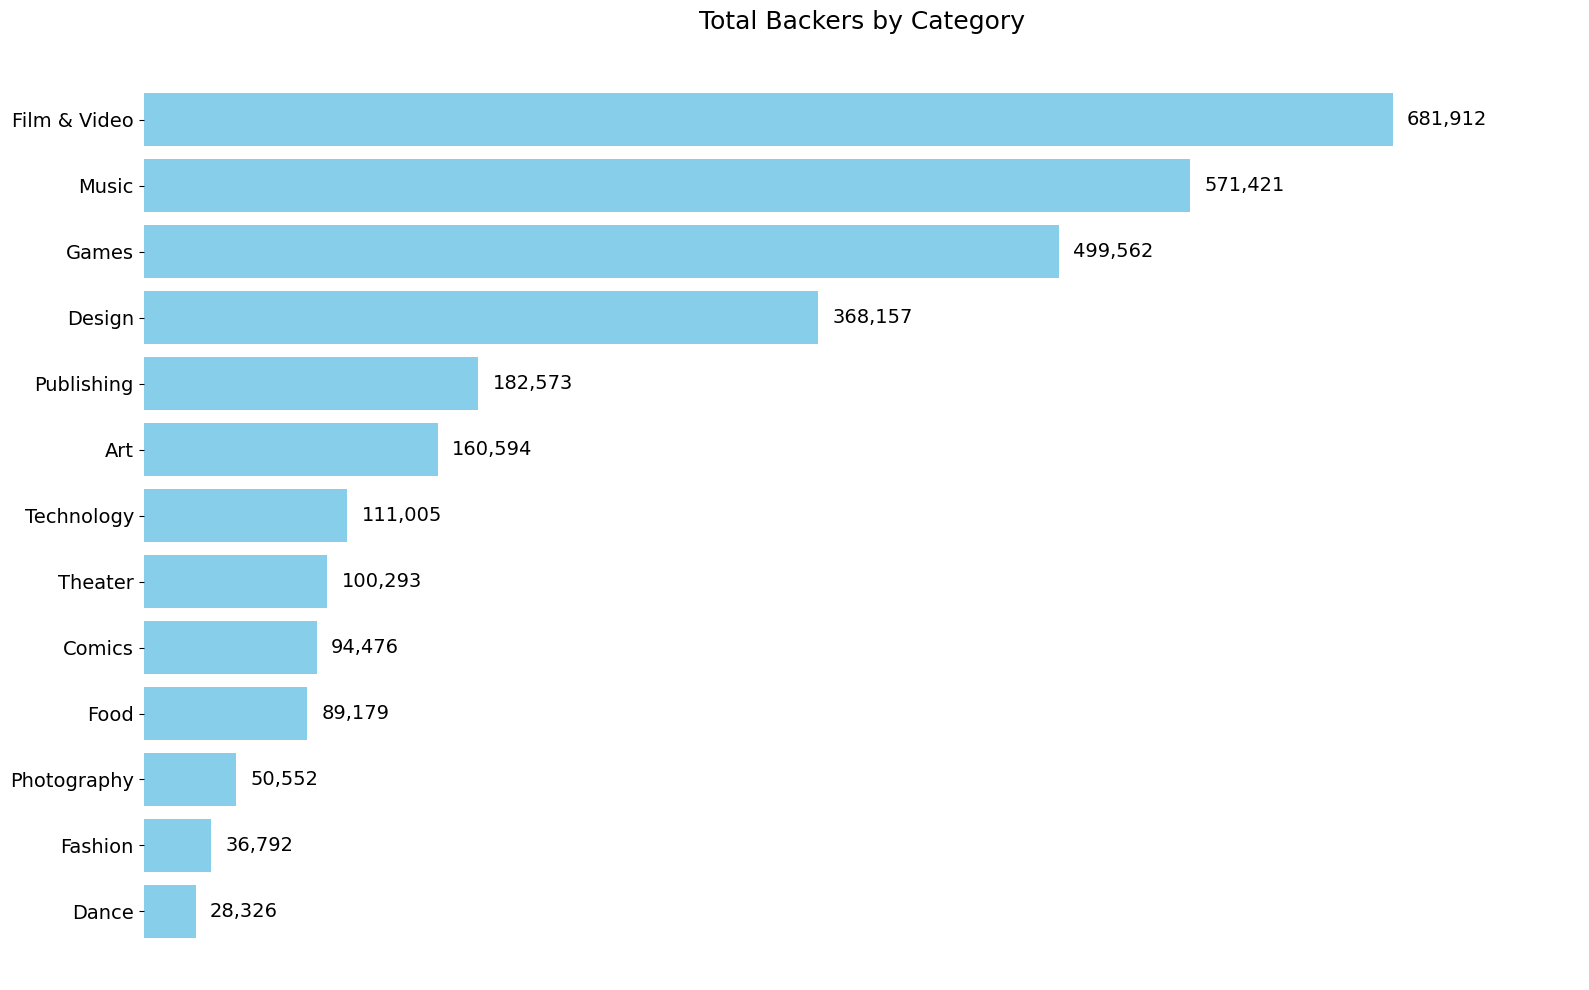

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = kickstarter_closed.copy()
df['backers'] = pd.to_numeric(df['backers'], errors='coerce')

by_cat = (
    df.dropna(subset=['backers'])
      .groupby('category', as_index=False)['backers']
      .sum()
      .sort_values('backers', ascending=True)
)

plt.figure(figsize=(16,10))
vals = by_cat['backers'].values
cats = by_cat['category'].values
y = np.arange(len(cats))
plt.barh(y, vals, color='skyblue')
plt.yticks(y, cats, fontsize=14)
plt.xticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('Total Backers by Category', fontsize=18, pad=16)
xmax = vals.max()*1.15
plt.xlim(0, xmax)
offset = xmax*0.01
for i, v in enumerate(vals):
    plt.text(v + offset, i, f"{int(v):,}", va='center', ha='left', fontsize=14, color='black')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()


## 2. Success Rate by Category

### 2.1 Which Kickstarter categories achieve the highest success rates?

In [97]:
success_rates = (
    kickstarter_closed
    .groupby('category')['status']
    .apply(lambda x: (x == 'successful').mean() * 100)
    .sort_values(ascending=False)
)

print(success_rates)

category
Dance           74.573864
Theater         70.669546
Music           67.540624
Art             57.057546
Comics          53.886010
Film & Video    50.996016
Food            50.503486
Photography     46.594203
Design          46.508648
Games           43.219178
Publishing      40.216867
Technology      39.344262
Fashion         32.907662
Name: status, dtype: float64


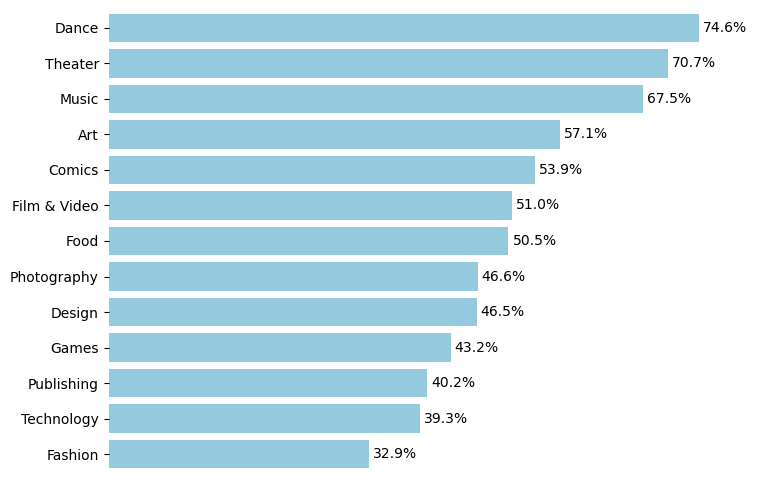

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

success_rate_by_category = (
    success_rates
    .reset_index()
    .rename(columns={'status': 'Success_Rate', 0: 'Success_Rate'})
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=success_rate_by_category,
    x='Success_Rate',
    y='category',
    color='skyblue',
    orient='h'
)

for index, value in enumerate(success_rate_by_category['Success_Rate']):
    plt.text(value + 0.5, index, f"{value:.1f}%", va='center')

plt.gca().set_xlabel('')
plt.gca().set_ylabel('')
plt.gca().set_title('')
plt.gca().set_xticks([])

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()


## 3. Funding Goals by Kickstarter Category

### 3.1 What is the range of funding goals across Kickstarter categories?

In [99]:
df = kickstarter_closed.copy()
df['goal'] = pd.to_numeric(df['goal'], errors='coerce')

table = (
    df[df['goal'] > 0]
      .groupby('category', as_index=False)['goal']
      .agg(Min_Goal='min', Max_Goal='max')
      .sort_values('category')
      .reset_index(drop=True))

display_table = table.copy()
for c in ['Min_Goal','Max_Goal']:
    display_table[c] = display_table[c].round(0).map(lambda v: f"${v:,.0f}")

print(display_table.to_string(index=False))


    category Min_Goal    Max_Goal
         Art       $0    $900,000
      Comics       $1     $65,000
       Dance       $5    $900,000
      Design      $15    $529,000
     Fashion       $1    $400,000
Film & Video       $0 $21,474,836
        Food       $1  $3,500,000
       Games      $13  $1,200,000
       Music       $1    $500,000
 Photography       $3    $150,000
  Publishing       $1    $140,000
  Technology      $50    $750,000
     Theater       $1    $250,000


### 3.2 Median Funding Goals by Category 

In [100]:
goal_median_by_category = (
    kickstarter_closed
    .groupby('category')['goal']
    .median()
    .sort_values(ascending=False)
)

goal_median_by_category = goal_median_by_category.apply(lambda x: f"${x:,.0f}")

print(goal_median_by_category)


category
Technology      $9,500
Food            $7,500
Design          $6,500
Film & Video    $5,000
Games           $5,000
Fashion         $4,500
Publishing      $3,500
Comics          $3,000
Music           $3,000
Photography     $3,000
Theater         $2,820
Art             $2,700
Dance           $2,500
Name: goal, dtype: object


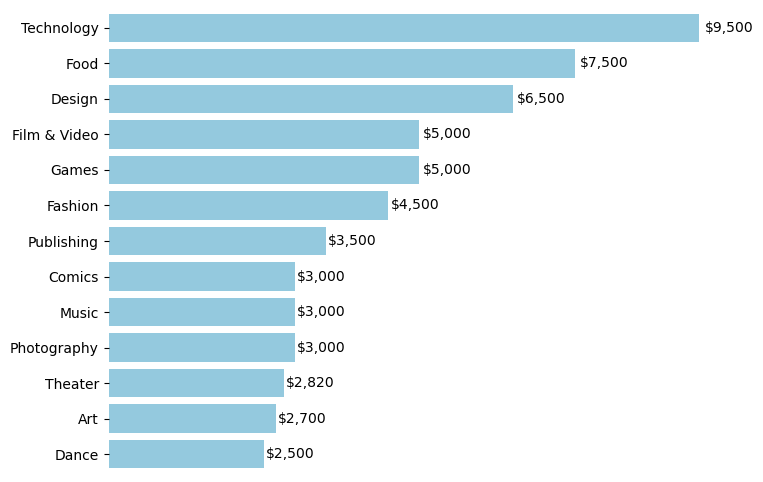

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

goal_median_values = (
    kickstarter_closed
    .groupby('category')['goal']
    .median()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'goal': 'Median_Goal'})
)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=goal_median_values,
    x='Median_Goal',
    y='category',
    color='skyblue',
    orient='h'
)

for index, value in enumerate(goal_median_values['Median_Goal']):
    plt.text(value + (value*0.01), index, f"${value:,.0f}", va='center')

plt.gca().set_xlabel('')
plt.gca().set_ylabel('')
plt.gca().set_title('')
plt.gca().set_xticks([])

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()


### 3.3 How do median funding goals relate to success rates across different Kickstarter categories?

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4520\483749333.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(data['category'], rotation=0, fontsize=14)


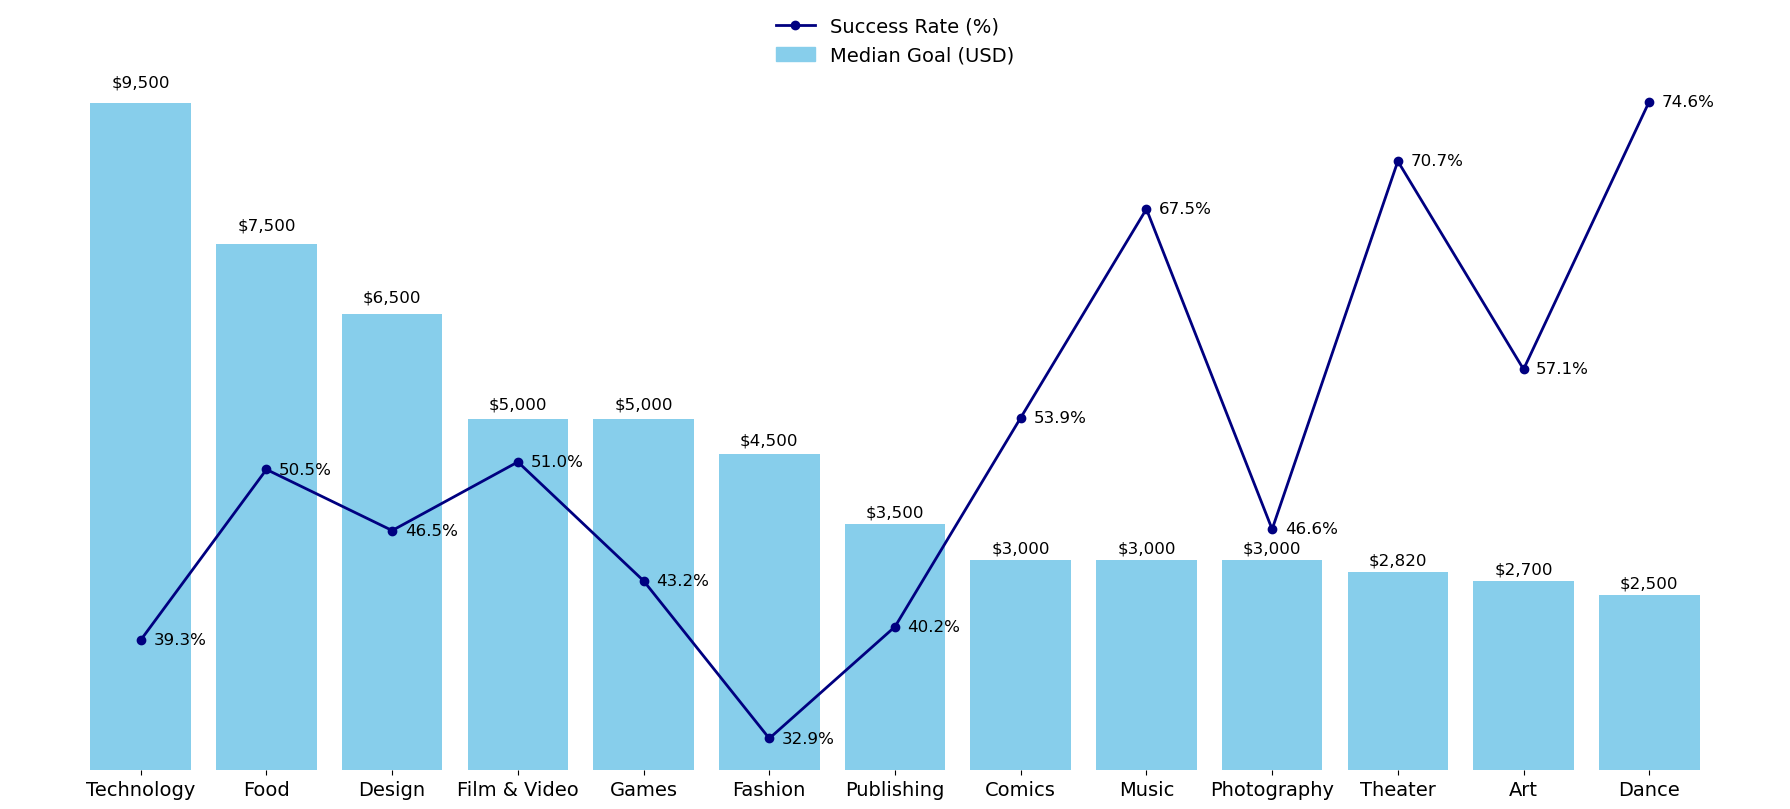

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

success_rates = (
    kickstarter_closed
    .groupby('category')['status']
    .apply(lambda x: (x == 'successful').mean() * 100)
)
goal_medians = (
    kickstarter_closed
    .groupby('category')['goal']
    .median()
)

data = (
    pd.DataFrame({
        'Success_Rate': success_rates,
        'Median_Goal': goal_medians
    })
    .sort_values('Median_Goal', ascending=False)
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(18, 8))

bars = ax1.bar(
    data['category'],
    data['Median_Goal'],
    color='skyblue',
    zorder=1,
    label='Median Goal (USD)'
)
ax1.set_yticks([])
ax1.set_ylabel('', fontsize=14)


ax1.set_xticklabels(data['category'], rotation=0, fontsize=14)


for bar in bars:
    h = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        h + (h * 0.02),
        f"${h:,.0f}",
        ha='center',
        va='bottom',
        zorder=3,
        fontsize=12
    )

ax2 = ax1.twinx()
line, = ax2.plot(
    data['category'],
    data['Success_Rate'],
    color='navy',
    marker='o',
    linewidth=2,
    zorder=2,
    label='Success Rate (%)'
)

for idx, val in enumerate(data['Success_Rate']):
    ax2.text(
        idx + 0.1,
        val,
        f"{val:.1f}%",
        ha='left',
        va='center',
        color='black',
        zorder=4,
        fontsize=12
    )

ax2.get_yaxis().set_visible(False)

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)

handles = [
    plt.Line2D([0], [0], color='navy', marker='o', linewidth=2, label='Success Rate (%)'),
    plt.Rectangle((0, 0), 1, 1, color='skyblue', label='Median Goal (USD)')
]
ax1.legend(handles=handles, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=14)

plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()


## 4. Median Daily Funding Rate by Category

### 4.1 Daily Funding Efficiency Across Kickstarter Categories

Calculates the median daily funding relative to goal and duration, showing the percentage of the goal achieved per day for each category.

In [104]:

kickstarter_closed['Funding_Speed'] = kickstarter_closed['pledged'] / kickstarter_closed['duration']
kickstarter_closed['Funding_vs_Goal'] = (kickstarter_closed['pledged'] / (kickstarter_closed['goal'] * kickstarter_closed['duration'])) * 100

median_speeds = (
    kickstarter_closed
    .groupby('category')[['Funding_Speed','Funding_vs_Goal']]
    .median()
    .sort_values('Funding_vs_Goal', ascending=False)
    .reset_index()
)

print(median_speeds)


        category  Funding_Speed  Funding_vs_Goal
0          Dance      59.286017         2.908725
1        Theater      53.821773         2.896625
2          Music      53.155233         2.516889
3            Art      35.541954         2.150274
4         Comics      31.014304         1.733333
5           Food      66.666667         1.626281
6   Film & Video      40.992891         1.553055
7         Design      50.666667         1.185714
8    Photography      25.524548         1.114784
9          Games      33.940280         0.758982
10    Technology      39.469174         0.574279
11    Publishing      14.975083         0.518920
12       Fashion      13.493931         0.366380


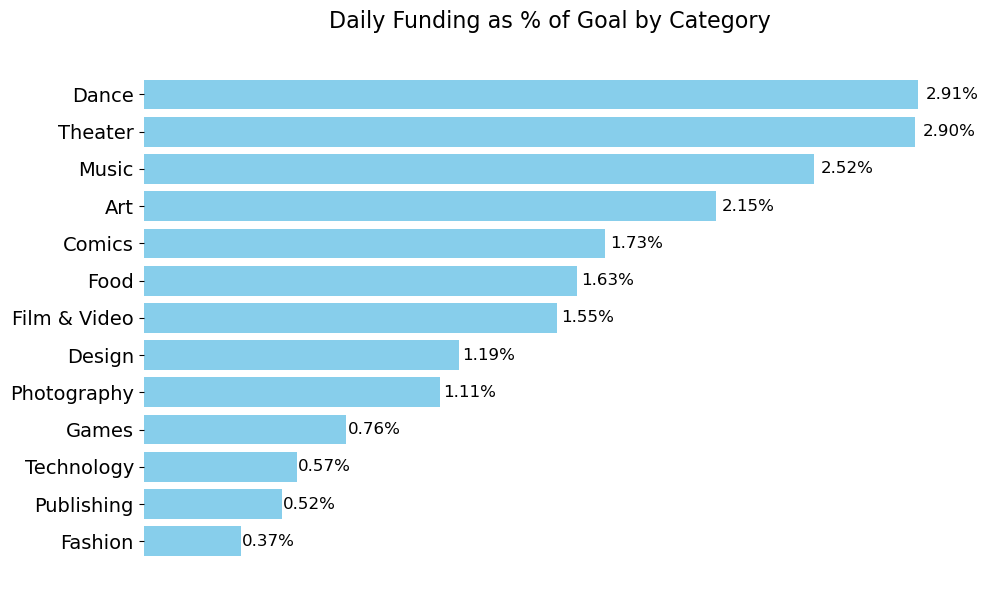

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

median_speeds = (
    kickstarter_closed
    .groupby('category')['Funding_vs_Goal']
    .median()
    .sort_values(ascending=True)
    .reset_index()
)

plt.figure(figsize=(10,6))
bars = plt.barh(
    median_speeds['category'],
    median_speeds['Funding_vs_Goal'],
    color='skyblue'
)
plt.title('Daily Funding as % of Goal by Category', fontsize=16, pad=20)
plt.xticks([])
plt.yticks(fontsize=14)
plt.xlabel('')
plt.ylabel('')

for index, value in enumerate(median_speeds['Funding_vs_Goal']):
    plt.text(
        value + (value*0.01),
        index,
        f"{value:.2f}%",
        va='center',
        fontsize=12
    )

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


## 5. Overfunding by Kickstarter Category

### 5.1 Which Kickstarter categories tend to exceed their funding goals the most

Shows median and mean percentage overfunding for successful projects in each category, highlighting which categories attract extra support beyond their goals.

In [106]:

df = kickstarter_closed.copy()
df['goal'] = pd.to_numeric(df['goal'], errors='coerce')
df['pledged'] = pd.to_numeric(df['pledged'], errors='coerce')
df = df[(df['goal'] > 0) & (df['pledged'] >= 0)]
df = df[df['status'] == 'successful']
df['Overfunding_Pct'] = ((df['pledged'] - df['goal']) / df['goal']) * 100

overfunding_by_cat = (
    df.groupby('category')['Overfunding_Pct']
      .agg(['median','mean','count'])
      .rename(columns={'median':'Median_Overfunding_%','mean':'Mean_Overfunding_%','count':'Projects'})
      .sort_values('Median_Overfunding_%', ascending=False)
      .reset_index()
)

print(overfunding_by_cat.round({'Median_Overfunding_%':1,'Mean_Overfunding_%':1}))


        category  Median_Overfunding_%  Mean_Overfunding_%  Projects
0          Games                  50.0               230.4       631
1     Technology                  38.0               160.4       288
2         Design                  33.1               655.6       726
3         Comics                  25.7               294.8       520
4    Photography                  12.7                37.4       643
5     Publishing                  12.6               145.3      1669
6          Music                  10.7                81.2      6775
7            Art                  10.3               579.5      2102
8           Food                   9.9                95.8       652
9        Theater                   9.8                91.1      1636
10       Fashion                   9.2               220.1       335
11  Film & Video                   8.4               411.9      6400
12         Dance                   8.1                38.0       525


### 5.2 Which individual projects raised the most beyond their goals?

In [107]:
df = kickstarter_closed.copy()
df['goal'] = pd.to_numeric(df['goal'], errors='coerce')
df['pledged'] = pd.to_numeric(df['pledged'], errors='coerce')

top_overfunded = (
    df[df['status']=='successful']
      .assign(Overfunding_Amount=lambda x: (x['pledged'] - x['goal']).clip(lower=0))
      .query('Overfunding_Amount > 0')
      .sort_values('Overfunding_Amount', ascending=False)
      .head(5)[['name','category','goal','pledged','Overfunding_Amount']]
      .reset_index(drop=True)
)

out = top_overfunded.copy()
for c in ['goal','pledged','Overfunding_Amount']:
    out[c] = out[c].round(0).map(lambda v: f"${v:,.0f}")

print(out.to_string(index=False))


                                        name category     goal     pledged Overfunding_Amount
Pebble: E-Paper Watch for iPhone and Android   Design $100,000 $10,266,845        $10,166,845
                       Double Fine Adventure    Games $400,000  $3,336,372         $2,936,372
                                 Wasteland 2    Games $900,000  $2,933,252         $2,033,252
                           Shadowrun Returns    Games $400,000  $1,836,447         $1,436,447
    Elevation Dock: The Best Dock For iPhone   Design  $75,000  $1,464,706         $1,389,706


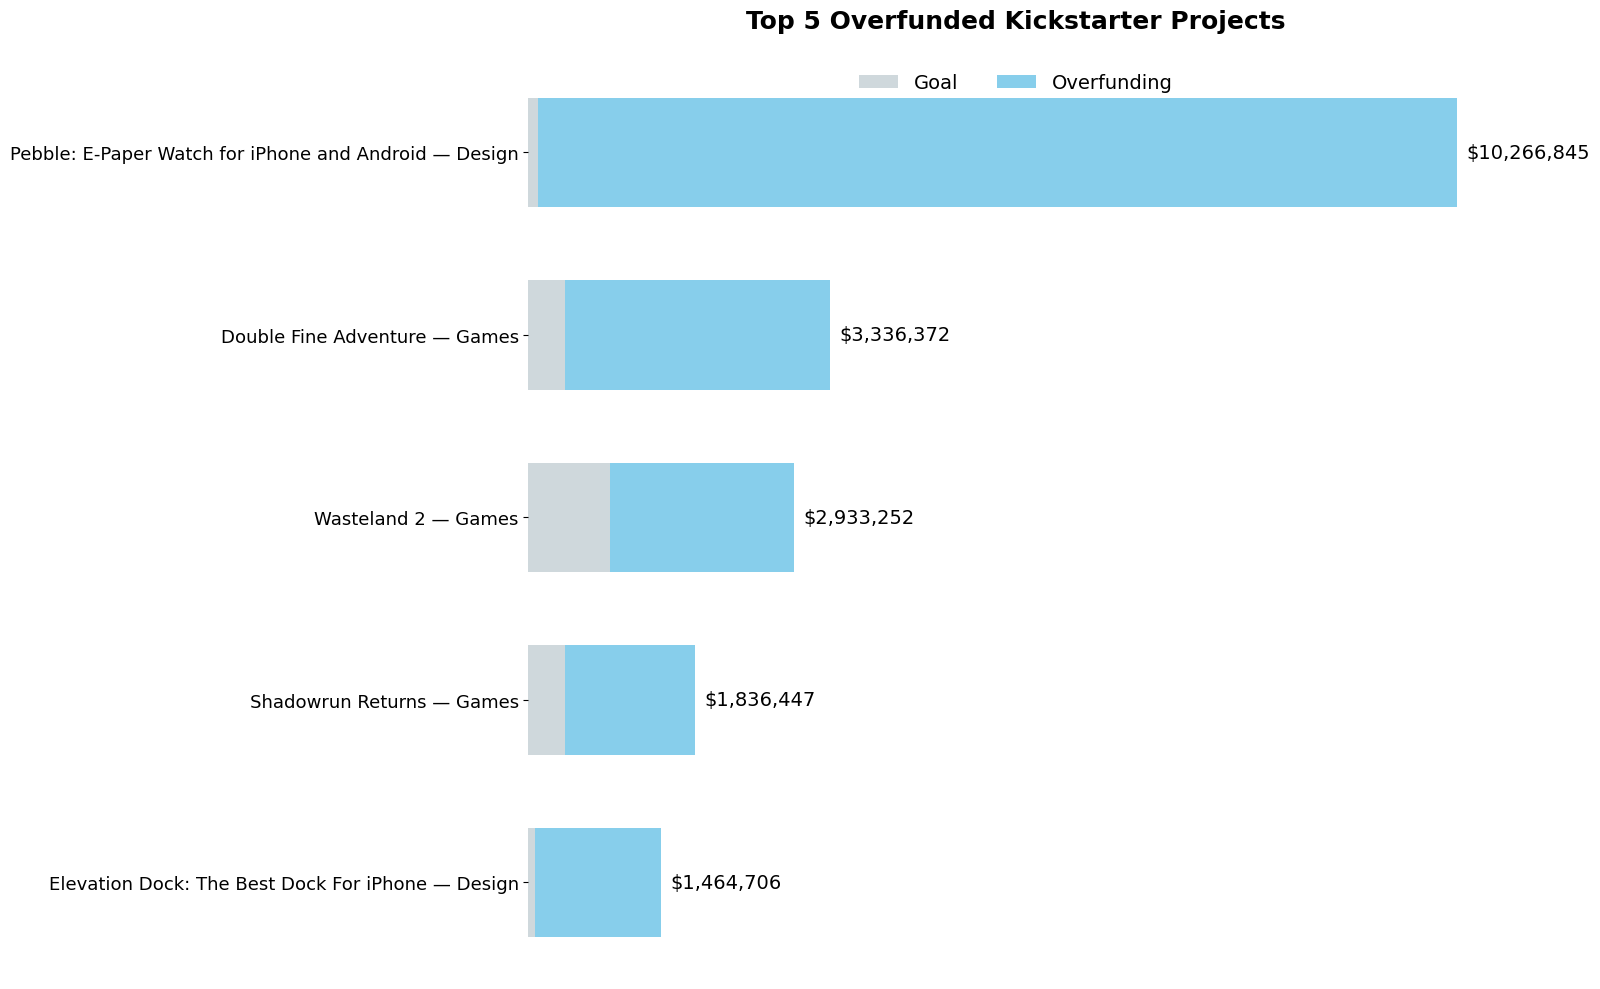

In [110]:
plt.figure(figsize=(16,10))

bars_goal = plt.barh(y, goals, color='#CFD8DC', label='Goal', height=0.6)
bars_over = plt.barh(y, over, left=goals, color='skyblue', label='Overfunding', height=0.6)

offset = totals.max()*0.01
for i in range(len(y)):
    plt.text(totals[i] + offset, y[i], f"${pledged[i]:,.0f}", 
             va='center', ha='left', fontsize=14, color='black')

plt.yticks(y, labels, fontsize=13)
plt.xticks([])
plt.xlabel('')
plt.ylabel('')
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.legend(frameon=False, loc='upper center', ncol=2, fontsize=14)  
plt.title("Top 5 Overfunded Kickstarter Projects", fontsize=18, weight='bold', pad=20) 

plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


## 6. Difficulty Score by Category

### 6.1 Struggle Score: Difficulty of Funding by Kickstarter Category

We used a **multiplication-based composite method** to quantify the struggle of each Kickstarter category. Specifically, we multiplied the category’s failure rate by the normalized total shortfall of failed projects (total gap divided by total goals). This approach combines both the likelihood of failure and the overall magnitude of missing the goal, producing a single ‘Struggle Score’ that highlights which categories are hardest to fund successfully.

In [ ]:
df = kickstarter_closed.copy()
df['goal'] = pd.to_numeric(df['goal'], errors='coerce')
df['pledged'] = pd.to_numeric(df['pledged'], errors='coerce')
df = df[df['goal'] > 0]

failure_rate = (
    df.groupby(['category','status'])
      .size()
      .unstack(fill_value=0)
      .reset_index()
)
failure_rate['Total'] = failure_rate.drop(columns='category').sum(axis=1)
failure_rate['FailureRate'] = failure_rate.get('failed', 0) / failure_rate['Total']
failure_rate = failure_rate[['category','FailureRate']]

failure_amount = (
    df[df['status'] == 'failed']
      .assign(Gap=lambda x: (x['goal'] - x['pledged']).clip(lower=0))
      .groupby('category', as_index=False)['Gap']
      .sum()
      .rename(columns={'Gap':'FailureAmount'})
)

total_goals = (
    df.groupby('category', as_index=False)['goal']
      .sum()
      .rename(columns={'goal':'TotalGoals'})
)

norm_failure = failure_amount.merge(total_goals, on='category', how='right')
norm_failure['FailureAmount'] = norm_failure['FailureAmount'].fillna(0)
norm_failure['NormFA'] = np.where(norm_failure['TotalGoals'] > 0,
                                  norm_failure['FailureAmount'] / norm_failure['TotalGoals'],
                                  0)

impact = failure_rate.merge(norm_failure[['category','NormFA']], on='category', how='inner')
impact['Struggle_Score'] = impact['FailureRate'] * impact['NormFA']
impact = impact.sort_values('Struggle_Score', ascending=False).reset_index(drop=True)

print(impact)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plot_df = impact.copy()
plot_df['FailureRate_%'] = plot_df['FailureRate'] * 100
plot_df['NormFA_%'] = plot_df['NormFA'] * 100
plot_df['Struggle_Score_%'] = plot_df['Struggle_Score'] * 100
plot_df = plot_df.sort_values('Struggle_Score_%', ascending=True)

plt.figure(figsize=(12,8))
bars = plt.barh(plot_df['category'], plot_df['Struggle_Score_%'], color='skyblue')
plt.title('Goal Achievement Difficulty (Failure Rate × Success Gap percentage) by Category', fontsize=20, pad=16)
plt.xticks([])
plt.xlabel('', fontsize=16)
plt.ylabel('', fontsize=16)
plt.yticks(fontsize=14)

for i, v in enumerate(plot_df['Struggle_Score_%']):
    plt.text(v + 0.8, i, f"{v:.1f}%", va='center', fontsize=14)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


## 7. Backer Contribution Patterns Across Kickstarter

### 7.1 Average Contribution per Supporter by Kickstarter Category and Subcategory

In [ ]:
df = kickstarter_closed.copy()
df['pledged'] = pd.to_numeric(df['pledged'], errors='coerce')
df['backers'] = pd.to_numeric(df['backers'], errors='coerce')
df = df[(df['pledged'] >= 0) & (df['backers'] > 0)]
df['Avg_Contrib'] = df['pledged'] / df['backers']

by_cat = (
    df.groupby('category')['Avg_Contrib']
      .agg(['median','mean','count'])
      .rename(columns={'median':'Median_Contrib','mean':'Mean_Contrib','count':'Projects'})
      .sort_values('Median_Contrib', ascending=False)
      .reset_index()
)

by_sub = (
    df.groupby(['category','subcategory'])['Avg_Contrib']
      .agg(['median','mean','count'])
      .rename(columns={'median':'Median_Contrib','mean':'Mean_Contrib','count':'Projects'})
      .sort_values('Median_Contrib', ascending=False)
      .reset_index()
)

disp_cat = by_cat.copy()
disp_cat['Median_Contrib'] = disp_cat['Median_Contrib'].round(2).map(lambda x: f"${x:,.2f}")
disp_cat['Mean_Contrib'] = disp_cat['Mean_Contrib'].round(2).map(lambda x: f"${x:,.2f}")

disp_sub = by_sub.copy()
disp_sub['Median_Contrib'] = disp_sub['Median_Contrib'].round(2).map(lambda x: f"${x:,.2f}")
disp_sub['Mean_Contrib'] = disp_sub['Mean_Contrib'].round(2).map(lambda x: f"${x:,.2f}")

print(" Contribution per Supporter by Category (sorted by median):")
print(disp_cat.to_string(index=False))

print("\nTop Subtypes by Contribution per Supporter (sorted by median):")
print(disp_sub.head(20).to_string(index=False))


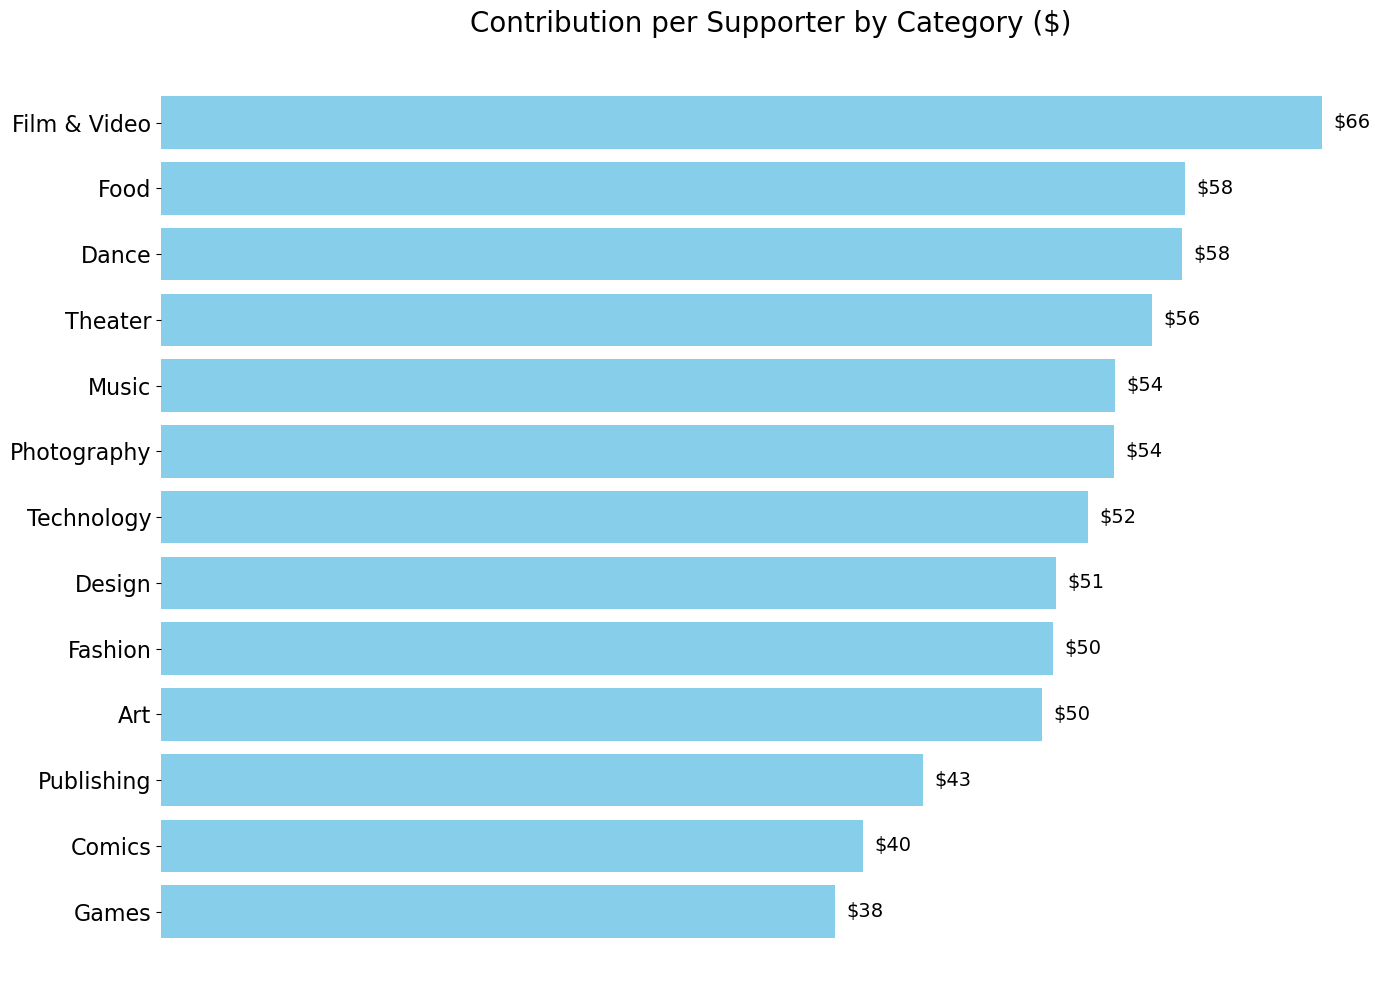

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = kickstarter_closed.copy()
df['pledged'] = pd.to_numeric(df['pledged'], errors='coerce')
df['backers'] = pd.to_numeric(df['backers'], errors='coerce')
df = df[(df['pledged'] >= 0) & (df['backers'] > 0)]
df['Avg_Contrib'] = df['pledged'] / df['backers']

by_cat = (
    df.groupby('category')['Avg_Contrib']
      .median()
      .sort_values(ascending=True)
      .reset_index(name='Median_Contrib')
)

plt.figure(figsize=(14,10))
bars = plt.barh(by_cat['category'], by_cat['Median_Contrib'], color='skyblue')
plt.xticks([])
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.title('Contribution per Supporter by Category ($)', fontsize=20, pad=16)
offset = by_cat['Median_Contrib'].max()*0.01
for i, v in enumerate(by_cat['Median_Contrib']):
    plt.text(v + offset, i, f"${v:,.0f}", va='center', fontsize=14, color='black')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.show()


## 8. Monthly Funding Effectiveness by Category

### 8.1 Monthly Funding Success Across Kickstarter Categories

In [120]:
df = kickstarter_closed.copy()
if 'funded_date' not in df.columns and 'funded date' in df.columns:
    df = df.rename(columns={'funded date':'funded_date'})

df['goal'] = pd.to_numeric(df['goal'], errors='coerce')
df['pledged'] = pd.to_numeric(df['pledged'], errors='coerce')
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
df = df[(df['goal'] > 0) & (df['pledged'] >= 0) & (df['duration'] > 0)]

df['funded_date'] = pd.to_datetime(df['funded_date'], errors='coerce')
df = df.dropna(subset=['funded_date'])
df['Month'] = df['funded_date'].dt.month

df['FundingSpeedNorm'] = (df['pledged'] / df['goal']) / df['duration']

result = (
    df.groupby(['category','Month'])
      .agg(
          TotalProjects=('status','count'),
          SuccessProjects=('status', lambda x: (x=='successful').sum()),
          MedianFundingSpeed=('FundingSpeedNorm','median')
      )
      .reset_index()
)

result['SuccessRate'] = result['SuccessProjects'] / result['TotalProjects']
result['Funding_Success_Score'] = result['SuccessRate'] * result['MedianFundingSpeed']
result['Funding_Success_Percent'] = result['Funding_Success_Score'] * 100

result = result.sort_values('Funding_Success_Percent', ascending=False).reset_index(drop=True)

print(result.head(20))


   category  Month  TotalProjects  SuccessProjects  MedianFundingSpeed  \
0     Dance     11             48               40            0.033351   
1     Dance      4             78               62            0.034146   
2     Dance     10             55               45            0.030899   
3   Theater      3            226              160            0.033450   
4     Dance      7             46               38            0.028122   
5     Dance      5             86               62            0.031715   
6   Theater      4            270              194            0.031610   
7   Theater     11            134               97            0.031039   
8     Dance      2             55               45            0.027434   
9   Theater      5            340              244            0.031157   
10  Theater      8            188              143            0.028457   
11  Theater      6            188              137            0.029622   
12    Dance     12             73     

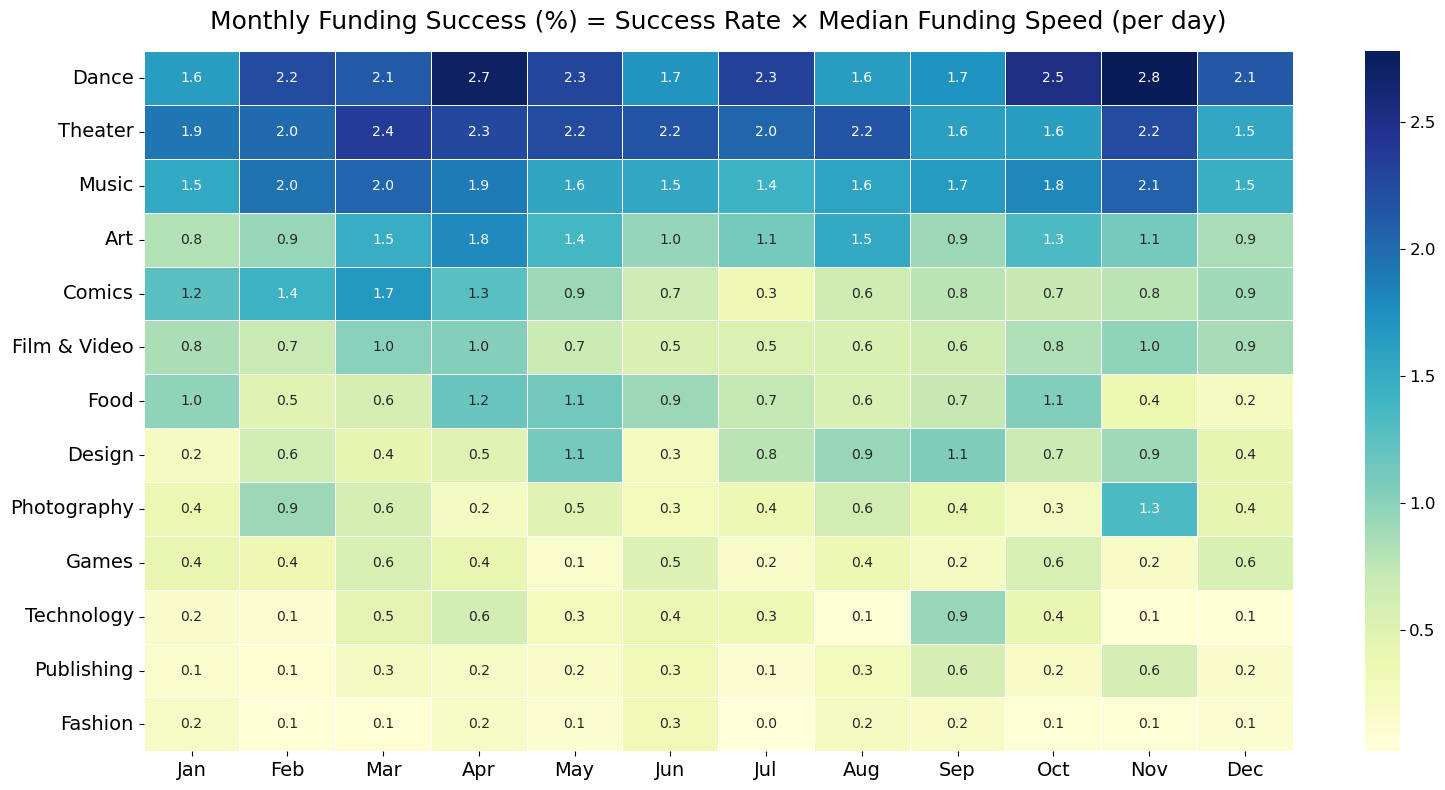

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

heat = result.copy()
heat['Funding_Success_%'] = heat['Funding_Success_Score'] * 100

pivot_score = (
    heat.pivot(index='category', columns='Month', values='Funding_Success_%')
        .reindex(columns=list(range(1,13)))
)

row_totals = pivot_score.sum(axis=1).sort_values(ascending=False)
pivot_score = pivot_score.loc[row_totals.index]

plt.figure(figsize=(16,8))
ax = sns.heatmap(
    pivot_score,
    cmap="YlGnBu",
    annot=True,
    fmt=".1f",
    cbar=True,
    linewidths=.5,
    linecolor='white'
)
ax.set_xticks(np.arange(12)+0.5)
ax.set_xticklabels([calendar.month_abbr[m] for m in range(1,13)], rotation=0, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.xlabel('')
plt.ylabel('')
plt.title('Monthly Funding Success (%) = Success Rate × Median Funding Speed (per day)', pad=16, fontsize=18)
plt.tight_layout()
plt.show()


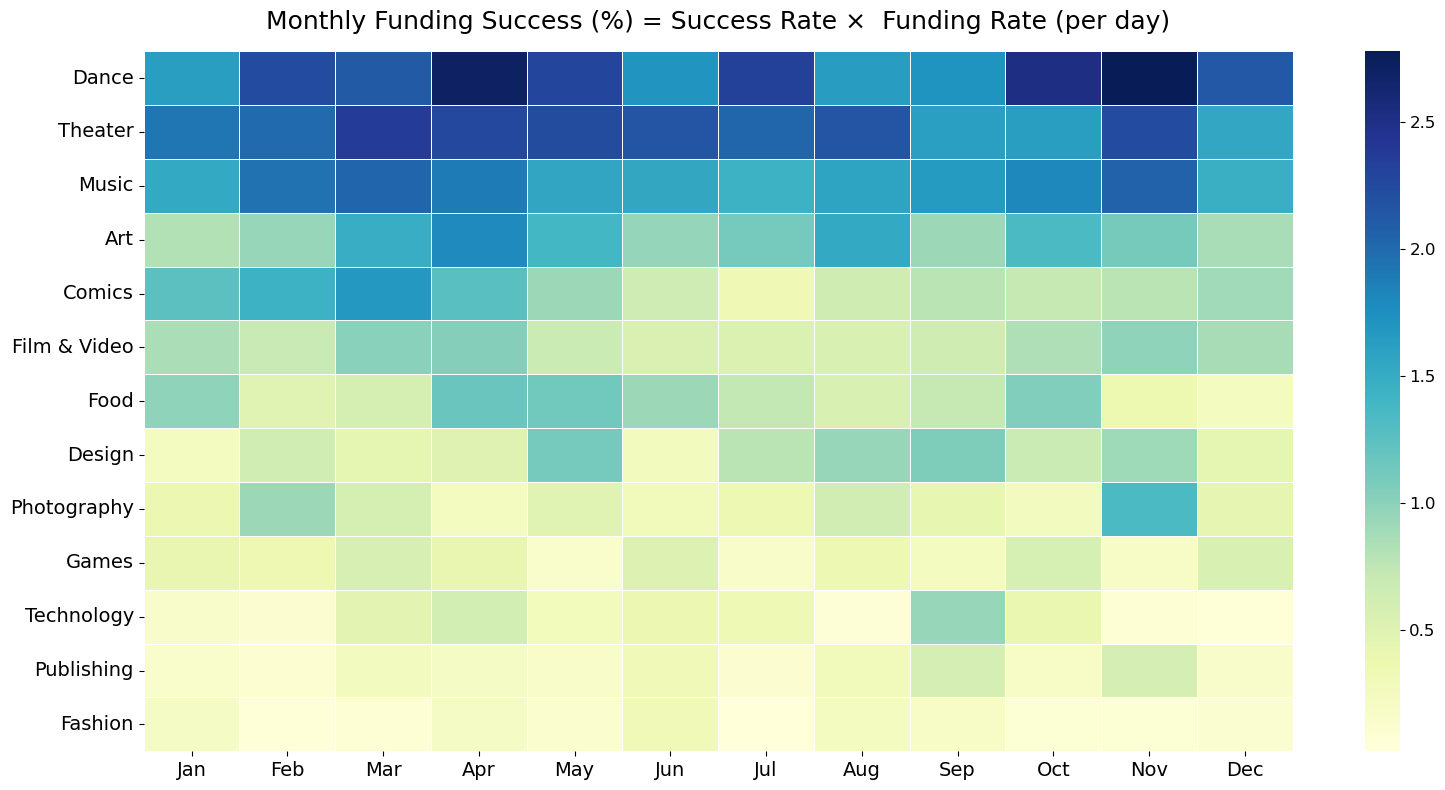

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

heat = result.copy()
heat['Funding_Success_%'] = heat['Funding_Success_Score'] * 100

pivot_score = (
    heat.pivot(index='category', columns='Month', values='Funding_Success_%')
        .reindex(columns=list(range(1,13)))
)

row_totals = pivot_score.sum(axis=1).sort_values(ascending=False)
pivot_score = pivot_score.loc[row_totals.index]

plt.figure(figsize=(16,8))
ax = sns.heatmap(
    pivot_score,
    cmap="YlGnBu",
    annot=False,
    cbar=True,
    linewidths=.5,
    linecolor='white'
)
ax.set_xticks(np.arange(12)+0.5)
ax.set_xticklabels([calendar.month_abbr[m] for m in range(1,13)], rotation=0, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.xlabel('')
plt.ylabel('')
plt.title('Monthly Funding Success (%) = Success Rate ×  Funding Rate (per day)', pad=16, fontsize=18)
plt.tight_layout()
plt.show()


## Insights & Recommendations

- **Success by Category**

    - Top performers: Dance (74.6%), Theater (70.7%), Music (67.5%)  
    - Lowest performers: Fashion (32.9%), Technology (39.3%), Publishing (40.2%)  
    - Insight: Creative projects with clear goals tend to succeed more than product-based projects with complex logistics.  

    **Recommendation:** Recognize the strengths and challenges of your category. If it’s a high-success one, keep your project focused and authentic to what backers already value. If it’s a lower-success one, anticipate barriers like cost, logistics, or trust, and counter them with strong prototypes, transparent communication, and realistic funding goals.  


- **Popularity vs. Success**

    - Most backers: Film & Video, Music, Games  
    - Large audience doesn’t guarantee success.  
    - Categories like Dance have smaller but highly committed audiences that consistently support projects.  

    **Recommendation:** Don’t rely only on a large audience. Prioritize uniqueness and creativity that spark passion. Building a loyal, engaged community—even if smaller—can lead to higher funding success than chasing sheer numbers.  


- **Risk Assessment**

    - High-risk categories: Fashion, Technology  
    - Physical products involve higher costs and delivery challenges.  

    **Recommendation:** In high-risk categories like Fashion and Technology, keep funding goals modest and prove deliverability. Clear plans and realistic expectations increase backer confidence.
  


- **Top-Contributing Categories**

    - Some categories attract backers who contribute more per person, showing the presence of a committed audience.  
    - Projects in these categories can achieve success through strong engagement rather than sheer number of backers.  

    **Recommendation:** Focus on cultivating depth of engagement. Highlight your project’s uniqueness, story, and long-term value so backers feel invested enough to pledge higher amounts, even if the supporter base is smaller.  


- **Seasonal and Timing Effects (Future Analysis)**

    - Optimal launch periods could improve funding success.  
    - Certain categories may perform better at specific times of year (e.g., Games/Tech before holidays, Art in spring).  

    **Recommendation:** Plan your launch strategically. Align with seasonal interest peaks and external events. For example, launching a game before holiday season or a food/art project in spring could boost visibility and backer enthusiasm.  


##  References

- Kickstarter Help. (2017). *How can I cancel my project?* Kickstarter. https://help.kickstarter.com/hc/en-us/articles/115005138393-How-can-I-cancel-my-project  

- Kickstarter Help. (2019). *What can Kickstarter do when a creator does not fulfill their project rewards?* Kickstarter. https://help.kickstarter.com/hc/en-us/articles/360039530654-What-can-Kickstarter-do-when-a-creator-does-not-fulfill-their-project-rewards1  

- Kickstarter Help. (n.d.). *Why is funding all-or-nothing?* Kickstarter. https://help.kickstarter.com/hc/en-us/articles/115005047893-Why-is-funding-all-or-nothing  
